### 양방향 LSTM을 이용한 품사 태깅

In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
# nltk를 통해 영어 코퍼스에 토큰화와 품사 태깅 전처리가 진행된 문장 데이터 받아오기
tagged_sentences = nltk.corpus.treebank.tagged_sents()
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences))

품사 태깅이 된 문장 개수:  3914


In [3]:
print(tagged_sentences[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


In [9]:
# 단어는 단어끼리, 태깅은 태깅끼리 저장 -> zip 함수 사용
sentences, pos_tags = [], [] 
for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence) #tagged_sentence 내 각각의 0번째는 sentence에 1번째는 tag_info에 저장
    sentences.append(list(sentence))
    pos_tags.append(list(tag_info))

In [10]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


In [11]:
print(sentences[1])
print(pos_tags[1])

['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.']
['NNP', 'NNP', 'VBZ', 'NN', 'IN', 'NNP', 'NNP', ',', 'DT', 'NNP', 'VBG', 'NN', '.']


샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


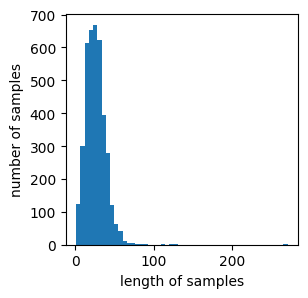

In [12]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.figure(figsize=(3, 3))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### 정수 인코딩

In [13]:
# 토크나이저 함수
def tokenize(samples):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(samples)
    return tokenizer

src_tokenizer = tokenize(sentences)  # 문장 데이터 tokenize
tar_tokenizer = tokenize(pos_tags)   # 품사 태깅 정보 데이터 tokenize

In [16]:
src_tokenizer.word_index

{',': 1,
 'the': 2,
 '.': 3,
 'of': 4,
 'to': 5,
 'a': 6,
 'in': 7,
 'and': 8,
 '*-1': 9,
 '0': 10,
 '*': 11,
 "'s": 12,
 'for': 13,
 'that': 14,
 '*t*-1': 15,
 '*u*': 16,
 '$': 17,
 '``': 18,
 "''": 19,
 'is': 20,
 'said': 21,
 'it': 22,
 'on': 23,
 '%': 24,
 'by': 25,
 'at': 26,
 'as': 27,
 'with': 28,
 'from': 29,
 'million': 30,
 'mr.': 31,
 '*-2': 32,
 'are': 33,
 'was': 34,
 'be': 35,
 '*t*-2': 36,
 'its': 37,
 'has': 38,
 'an': 39,
 'new': 40,
 'have': 41,
 "n't": 42,
 'but': 43,
 'he': 44,
 'or': 45,
 'will': 46,
 'they': 47,
 'company': 48,
 '--': 49,
 'which': 50,
 'this': 51,
 'u.s.': 52,
 'says': 53,
 'year': 54,
 'about': 55,
 'would': 56,
 'more': 57,
 'were': 58,
 'market': 59,
 'their': 60,
 'than': 61,
 'stock': 62,
 ';': 63,
 'who': 64,
 'trading': 65,
 'had': 66,
 'also': 67,
 'president': 68,
 'billion': 69,
 'up': 70,
 'one': 71,
 'been': 72,
 'some': 73,
 ':': 74,
 'other': 75,
 'not': 76,
 'program': 77,
 '*-3': 78,
 'his': 79,
 'because': 80,
 'if': 81,
 'could'

In [17]:
tar_tokenizer.word_index

{'nn': 1,
 'in': 2,
 'nnp': 3,
 'dt': 4,
 '-none-': 5,
 'nns': 6,
 'jj': 7,
 ',': 8,
 '.': 9,
 'cd': 10,
 'vbd': 11,
 'rb': 12,
 'vb': 13,
 'cc': 14,
 'to': 15,
 'vbn': 16,
 'vbz': 17,
 'prp': 18,
 'vbg': 19,
 'vbp': 20,
 'md': 21,
 'pos': 22,
 'prp$': 23,
 '$': 24,
 '``': 25,
 "''": 26,
 ':': 27,
 'wdt': 28,
 'jjr': 29,
 'nnps': 30,
 'wp': 31,
 'rp': 32,
 'jjs': 33,
 'wrb': 34,
 'rbr': 35,
 '-rrb-': 36,
 '-lrb-': 37,
 'ex': 38,
 'rbs': 39,
 'pdt': 40,
 '#': 41,
 'wp$': 42,
 'ls': 43,
 'fw': 44,
 'uh': 45,
 'sym': 46}

In [18]:
vocab_size = len(src_tokenizer.word_index) + 1   # +1: 패딩 시 생기는 0을 고려
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


In [19]:
# 정수 인코딩
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

In [22]:
print(X_train[2])
print(y_train[2])

[2917, 5603, 1, 1136, 86, 331, 8, 602, 177, 4, 3747, 1046, 892, 893, 1, 34, 483, 9, 6, 2025, 332, 4, 51, 1047, 435, 2918, 3]
[3, 3, 8, 10, 6, 7, 14, 7, 1, 2, 3, 3, 3, 3, 8, 11, 16, 5, 4, 7, 1, 2, 4, 7, 7, 1, 9]


In [23]:
# 샘플 데이터의 길이를 150으로 맞춤
max_len = 150
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)   # post: 뒤에 패딩 추가
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [26]:
X_train[:3]

array([[5601, 3746,    1, 2024,   86,  331,    1,   46, 2405,    2,  131,
          27,    6, 2025,  332,  459, 2026,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [27]:
# train,test 분리
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [28]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150)


#### 양방향 LSTM을 이용해서 pos tagging

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True))) # 다대다 -> return_sequences=True
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1457664   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, None, 47)         12079     
 ibuted)                                                         
                                                                 
Total params: 1,732,911
Trainable params: 1,732,911
Non-trainable params: 0
_________________________________________________________________


In [30]:
# y 변수에 대해 원핫인코딩 x -> sparses_categorical_crossentropy를 사용한다
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=7, validation_data=(X_test, y_test))

Epoch 1/7
25/25 [==============================] - 50s 2s/step - loss: 3.4288 - accuracy: 0.1696 - val_loss: 2.9925 - val_accuracy: 0.1742
Epoch 2/7
25/25 [==============================] - 48s 2s/step - loss: 2.8999 - accuracy: 0.2067 - val_loss: 2.7657 - val_accuracy: 0.2610
Epoch 3/7
25/25 [==============================] - 51s 2s/step - loss: 2.5503 - accuracy: 0.4035 - val_loss: 2.2351 - val_accuracy: 0.4778
Epoch 4/7
25/25 [==============================] - 51s 2s/step - loss: 1.8794 - accuracy: 0.5342 - val_loss: 1.5227 - val_accuracy: 0.6371
Epoch 5/7
25/25 [==============================] - 52s 2s/step - loss: 1.1951 - accuracy: 0.7355 - val_loss: 0.9297 - val_accuracy: 0.8053
Epoch 6/7
25/25 [==============================] - 53s 2s/step - loss: 0.6700 - accuracy: 0.8750 - val_loss: 0.5651 - val_accuracy: 0.8818
Epoch 7/7
25/25 [==============================] - 53s 2s/step - loss: 0.3760 - accuracy: 0.9295 - val_loss: 0.3975 - val_accuracy: 0.9067


In [31]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

25/25 [==============================] - 1s 47ms/step - loss: 0.3974 - accuracy: 0.9067

 테스트 정확도: 0.9067


In [35]:
y_predicted

array([[ 2,  1,  8,  3, 17,  4, 12, 16,  1,  2,  3,  3,  1,  6,  8, 17,
         5,  5,  4,  3,  3,  1,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9]], dtype=int64)

In [32]:
index_to_word = src_tokenizer.index_word
index_to_tag = tar_tokenizer.index_word

i = 10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측값 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 레이블로 변환.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], y_test[i], y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_tag[tag].upper(), index_to_tag[pred].upper()))

1/1 [==============================] - 2s 2s/step
단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      RB
respected        : VBN     VBN
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .


In [36]:
i=100
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측값 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 레이블로 변환.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], y_test[i], y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_tag[tag].upper(), index_to_tag[pred].upper()))

1/1 [==============================] - 0s 21ms/step
단어             |실제값  |예측값
-----------------------------------
pressures        : NNS     NNS
began            : VBD     VBD
*-1              : -NONE-  -NONE-
to               : TO      TO
build            : VB      VB
.                : .       .


In [37]:
i=123
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측값 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 레이블로 변환.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], y_test[i], y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_tag[tag].upper(), index_to_tag[pred].upper()))

1/1 [==============================] - 0s 21ms/step
단어             |실제값  |예측값
-----------------------------------
the              : DT      DT
mcalpine         : NNP     NNP
family           : NN      NN
,                : ,       ,
which            : WDT     WDT
*t*-1            : -NONE-  -NONE-
operates         : VBZ     VBZ
a                : DT      DT
number           : NN      NN
of               : IN      IN
multinational    : JJ      JJ
companies        : NNS     NNS
,                : ,       ,
including        : VBG     VBG
a                : DT      DT
london-based     : JJ      JJ
engineering      : NN      NN
and              : CC      CC
construction     : NN      NN
company          : NN      NN
,                : ,       ,
also             : RB      RB
lent             : VBD     VBN
to               : TO      TO
meridian         : NNP     NNP
national         : NNP     NNP
$                : $       $
500,000          : CD      CD
*u*              : -NONE-  -NONE-
.   

### 개체명 인식

#### nltk를 이용한 개체명 인식 - NER chunker      
nltk의 개체명 인식 함수 ne_chunk는 품사 태깅이 먼저 수행되어야 함

In [1]:
from nltk import word_tokenize, pos_tag, ne_chunk

sentence = "James is working at Disney in London"
# 토큰화 후 품사 태깅
tokenized_sentence = pos_tag(word_tokenize(sentence))
print(tokenized_sentence)

[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]


In [39]:
# 개체명 인식
ner_sentence = ne_chunk(tokenized_sentence)
print(ner_sentence)

(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


데이터: CONLL2003         
개체명 인식을 위한 전통적인 영어 데이터셋         
               
               
데이터 예시            
          
EU NNP B-NP B-ORG            
rejects VBZ B-VP O         
                  
[단어] [품사 태깅] [청크 태깅] [개체명 태깅] 의 형식으로 이루어져 있음

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
# 개체명 인식을 위한 데이터 전처리
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20RNN%20Sequence%20Labeling/dataset/train.txt", filename="train.txt")

f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

In [42]:
print("전체 샘플 개수: ", len(tagged_sentences))

전체 샘플 개수:  14041


In [45]:
tagged_sentences[:3]

[[['eu', 'B-ORG'],
  ['rejects', 'O'],
  ['german', 'B-MISC'],
  ['call', 'O'],
  ['to', 'O'],
  ['boycott', 'O'],
  ['british', 'B-MISC'],
  ['lamb', 'O'],
  ['.', 'O']],
 [['peter', 'B-PER'], ['blackburn', 'I-PER']],
 [['brussels', 'B-LOC'], ['1996-08-22', 'O']]]

In [4]:
# 단어는 단어끼리, 개체명 정보는 정보끼리 따로 저장 -> zip 함수 활용
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 14,041개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [47]:
print(sentences[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']


In [48]:
print(ner_tags[0])

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


In [50]:
print(sentences[12])
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


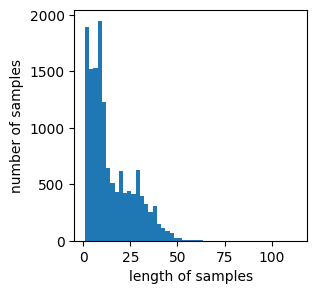

In [52]:
# 전체 데이터 길이 분포 확인
print('샘플의 최대 길이 : %d' % max(len(sentence) for sentence in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.figure(figsize=(3,3))
plt.hist([len(sentence) for sentence in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

문장 데이터의 모든 단어를 사용하지 않고, 빈도수가 높은 4000개의 단어만 사용

In [5]:
vocab_size = 4000
# oov_token: train에는 없었지만 test에는 있었던 단어에 대해 'OOV'라고 토큰을 지정해줌
# 여기서는 단어 개수를 4000개로 지정하므로, 빈도 상위 4000개보다 낮은 단어 또한 OOV로 인코딩됨
src_tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [6]:
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 : 10


In [7]:
# 정수 인코딩
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [65]:
print(X_train[0])
print(y_train[0])

[989, 1, 205, 629, 7, 3939, 216, 1, 3]
[4, 1, 7, 1, 1, 1, 7, 1, 1]


In [8]:
# OOV 처리된 단어 및 문장 확인
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [67]:
# 첫번째 문장을 디코딩해서 확인
decoded = []
for index in X_train[0] : # 첫번째 샘플 안의 각 정수로 변환된 단어에 대해서
    decoded.append(index_to_word[index]) # 단어로 변환

print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


In [9]:
# 패딩
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [10]:
y_train

array([[4, 1, 7, ..., 0, 0, 0],
       [3, 5, 0, ..., 0, 0, 0],
       [2, 1, 0, ..., 0, 0, 0],
       ...,
       [4, 1, 4, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [4, 1, 4, ..., 0, 0, 0]])

In [70]:
y_train.shape

(14041, 70)

In [11]:
# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

# 태깅 정보인 y 데이터에 대해 원핫 인코딩 수행
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [73]:
y_train[0]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 

In [74]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2809, 70)
테스트 샘플 레이블의 크기 : (2809, 70, 10)


#### 양방향 LSTM을 통한 개체명 인식

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 128)           512000    
                                                                 
 bidirectional (Bidirectiona  (None, 70, 256)          263168    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 70, 10)           2570      
 ibuted)                                                         
                                                                 
Total params: 777,738
Trainable params: 777,738
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=8, validation_data=(X_test, y_test))

Epoch 1/8
88/88 [==============================] - 38s 382ms/step - loss: 0.9563 - accuracy: 0.8231 - val_loss: 0.6476 - val_accuracy: 0.8332
Epoch 2/8
88/88 [==============================] - 40s 455ms/step - loss: 0.5115 - accuracy: 0.8470 - val_loss: 0.4227 - val_accuracy: 0.8722
Epoch 3/8
88/88 [==============================] - 41s 469ms/step - loss: 0.3633 - accuracy: 0.8916 - val_loss: 0.3024 - val_accuracy: 0.9142
Epoch 4/8
88/88 [==============================] - 41s 471ms/step - loss: 0.2530 - accuracy: 0.9276 - val_loss: 0.2215 - val_accuracy: 0.9376
Epoch 5/8
88/88 [==============================] - 41s 464ms/step - loss: 0.1866 - accuracy: 0.9454 - val_loss: 0.1822 - val_accuracy: 0.9488
Epoch 6/8
88/88 [==============================] - 41s 464ms/step - loss: 0.1505 - accuracy: 0.9558 - val_loss: 0.1704 - val_accuracy: 0.9524
Epoch 7/8
88/88 [==============================] - 41s 471ms/step - loss: 0.1303 - accuracy: 0.9617 - val_loss: 0.1664 - val_accuracy: 0.9538
Epoch 

In [14]:
model.evaluate(X_test, y_test)

88/88 [==============================] - 2s 23ms/step - loss: 0.1599 - accuracy: 0.9559


[0.15992742776870728, 0.9559136629104614]

In [80]:
# 정확도가 
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

88/88 [==============================] - 4s 43ms/step - loss: 0.1610 - accuracy: 0.9552

 테스트 정확도: 0.9552


In [16]:
s = model.predict(X_test)

88/88 [==============================] - 2s 20ms/step


In [81]:
i = 10 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict(np.array([X_test[i]]))

# 확률 벡터를 정수 레이블로 변경.
y_predicted = np.argmax(y_predicted, axis=-1)

# 원-핫 벡터를 정수 인코딩으로 변경.
labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag].upper(), index_to_ner[pred].upper()))

1/1 [==============================] - 2s 2s/step
단어             |실제값  |예측값
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   I-PER
,                : O       O
whose            : O       O
republican       : B-MISC  B-MISC
husband          : O       O
was              : O       O
OOV              : O       O
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   B-PER
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  I-MISC
convention       : I-MISC  I-MISC
on               : O       O
monday           : O       O
night            : O       O
to         

#### 평가지표: F1-score
개체명 인식의 경우, 그 어떤 개체도 아님을 뜻하는 'O' 태깅이 대다수를 차지하기 때문에 평가 지표로 accuracy를 활용하는 것이 적절하지 않을 수 있음        
(모두 'O'로 예측할 경우에도, 대다수가 개체가 아니라면 높은 정확도를 가질 수 있다)      
-> precision과 recall의 조화평균인 f1-score를 사용     
*precision: true로 예측한 값중 실제로 true인 비율       
*recall: 실제로 true인 값 중 true로 잘 예측한 비율

#### F1 score 사용 - seqeval
*seqeval: sequence 레이블링에 대한 평가를 위해 만들어진 파이썬 프레임워크          
(ex. 개체명 인식, pos tagging 등)

In [21]:
#!pip install seqeval

In [24]:
from seqeval.metrics import f1_score, classification_report

In [23]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

print(index_to_ner)

{1: 'o', 2: 'b-loc', 3: 'b-per', 4: 'b-org', 5: 'i-per', 6: 'i-org', 7: 'b-misc', 8: 'i-loc', 9: 'i-misc', 0: 'PAD'}


In [25]:
def sequences_to_tag(sequences):
    result = []
    # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
    for sequence in sequences:
        word_sequence = []
        # 시퀀스로부터 확률 벡터 또는 원-핫 벡터를 하나씩 꺼낸다.
        for pred in sequence:
            # 정수로 변환. 예를 들어 pred가 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            pred_index = np.argmax(pred)            
            # index_to_ner을 사용하여 정수를 태깅 정보로 변환. 'PAD'는 'O'로 변경.
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "o"))
        result.append(word_sequence)
    return result

y_predicted = model.predict([X_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

88/88 [==============================] - 3s 19ms/step


C:\Users\yejin.hwang\AppData\Local\Programs\Python\Python37\py37\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: b-org seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\yejin.hwang\AppData\Local\Programs\Python\Python37\py37\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: i-org seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\yejin.hwang\AppData\Local\Programs\Python\Python37\py37\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: o seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\yejin.hwang\AppData\Local\Programs\Python\Python37\py37\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: b-per seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\yejin.hwang\AppData\Local\Programs\Python\Python37\py37\lib\site-packages\seqeval\m

F1-score: 76.5%
              precision    recall  f1-score   support

           _       0.75      0.69      0.72      3375
         loc       0.87      0.85      0.86      1379
        misc       0.85      0.68      0.76       657
         org       0.76      0.72      0.74      1239
         per       0.80      0.80      0.80      1298

   micro avg       0.79      0.74      0.77      7948
   macro avg       0.81      0.75      0.78      7948
weighted avg       0.79      0.74      0.76      7948

